In [1]:
import os
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

from diffEq import odes, plot

## Test differential equation:

$\frac{dT(t)}{dt} = r(T_{env} - T(t))$



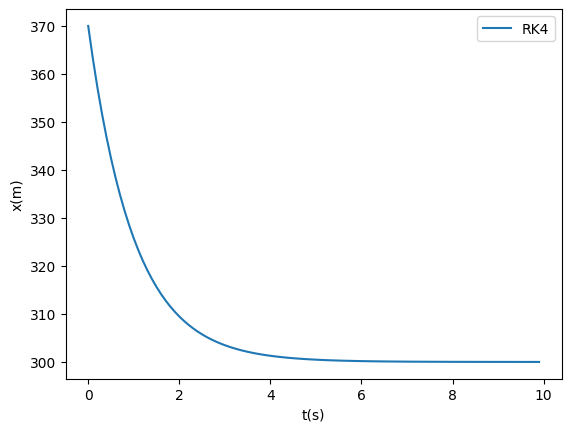

In [2]:
r = 1
T_env = 300

# args = [T]
def DT(t, args):
    return r*(T_env - args[0])

cooling_obj = odes([DT], [370])

t_list, T_list = cooling_obj.solve_Runge_Kutta(0, 10, h=0.1, stage=4)
solutions = {"RK4": (t_list, T_list)}

plot(solutions)

# Elements to change to test model architecture

- n_step: Number of time points when simulating T(t)
- n_exp: Number of experiment to train model on
- n_train: Number of points used for training
- Number of hidden layers
- Number of neurons per hidden layer
- nn.Linear (other?)
- Activation function (now tanh)
- Loss function: Now nn.MSELoss(), Means Squared Error:
$ 
\begin{equation}
MSE = \frac{1}{N}\sum_{i=1}^{N}\left(y_i - \tilde{y}_i\right)^2
\end{equation}
$
- Optimizer and its parameters: Now optim.Adam
- The number of epochs (number of times we adapt the weights and biases)

## Getting device for training

In [3]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
    print(device)

## Preparing data

Here we create synthetic data to test the model architecture. In real life (in a real experiment) we get our data and then apply our model to it. But now since we want to build a model, we create synthetic data to train it (and test it). So in real life of course we don't know T(t) exactly since this is what we want to calculate with our ML model.

In [4]:
n_step = 200 #number of time points when simulating T(t)
n_exp = 500 #number of experiment to train model on
n_train = 400

#For each of the 100 experiments we now have a unique (r, T_env, T_0) triplet
torch.manual_seed(0) #get the same random numbers everytime you run the code
r_tensor = torch.rand(n_exp, 1) #random cooling rate between 0 and 1 (100 times)
T_env_tensor = torch.rand(n_exp, 1) * 500 #random ambient temperature between 0 and 500 (100 times)
T_0_tensor = T_env_tensor + torch.rand(n_exp, 1) * 100 #Initial temperature, slightly higher than the ambient temperature (between 0K and 100K hotter) (100 times)


t_tensor = torch.linspace(0, 50, n_step) #n_step (100) equally spaced time points between 0 and 50 seconds
T_tensor = T_env_tensor - (T_env_tensor - T_0_tensor)*torch.exp(-r_tensor * t_tensor) #creates 100 * 100 points, where each experiment has its own sampled datapoints (from exact solution)

# Split data into training and test sets
r_train, T_env_train, T_0_train, T_train = r_tensor[:n_train], T_env_tensor[:n_train], T_0_tensor[:n_train], T_tensor[:n_train]
X_train = torch.cat((r_train, T_env_train, T_0_train), 1) #C_train is a 90*3 tensor containing input features for training

#Standardize training inputs X_norm = X-µ/std, so each feature (column) has mean 0 and std1
X_train_mean = X_train.mean(dim=0, keepdim=True)
X_train_std = X_train.std(dim=0, keepdim=True)
X_train = (X_train - X_train_mean) / X_train_std

#Do the same for test data
r_test, T_env_test, T_0_test, T_test = r_tensor[n_train:], T_env_tensor[n_train:], T_0_tensor[n_train:], T_tensor[n_train:]
X_test = torch.cat((r_test, T_env_test, T_0_test), 1)

X_test_mean = X_test.mean(dim=0, keepdim=True)
X_test_std = X_test.std(dim=0, keepdim=True)
#X_test = (X_test - X_test_mean) / X_test_std       #test 1
X_test = (X_test - X_train_mean) / X_train_std


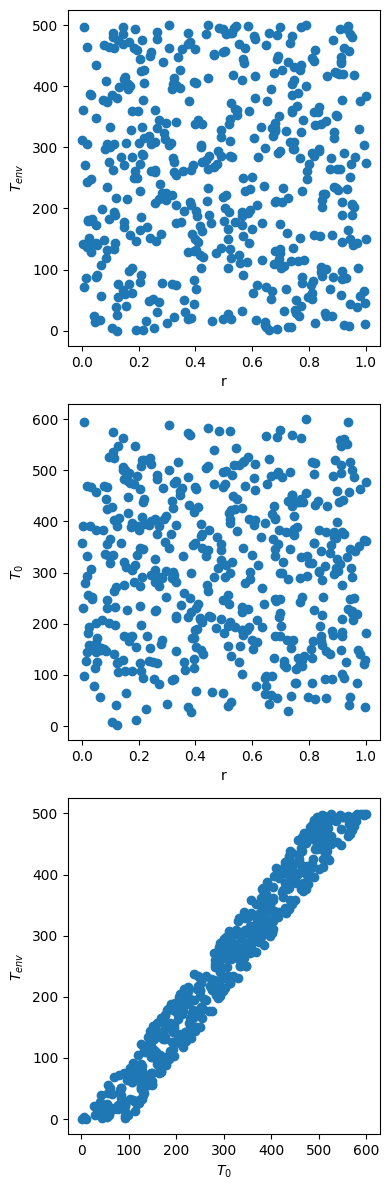

In [5]:
#Check if we cover the phase space evenly
fig, ax = plt.subplots(3,1, figsize = (4,12))

ax[0].scatter(r_tensor, T_env_tensor)
ax[0].set_xlabel("r")
ax[0].set_ylabel(r"$T_{env}$")

ax[1].scatter(r_tensor, T_0_tensor)
ax[1].set_xlabel("r")
ax[1].set_ylabel(r"$T_0$")

ax[2].scatter(T_0_tensor, T_env_tensor)
ax[2].set_xlabel(r"$T_0$")
ax[2].set_ylabel(r"$T_{env}$")

plt.tight_layout()
plt.show()

## Defining the model

In [6]:
class CoolingModel(nn.Module):
    def __init__(self, n_step):
        super().__init__()
        self.fc1 = nn.Linear(3, 32)    # Takes input vectors of size 3 (r, T_env, T_0) and outputs 32 hidden features
        self.fc2 = nn.Linear(32, n_step)  # Maps 32 hidden features to output of size n_size (predicted temperature curve over time)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))     # smooth activation
        x = self.fc2(x)
        return x

# Initiate the model
model = CoolingModel(n_step) #creates a model object using the class, with the chosen number of time steps

In [7]:
# Loss function and optimizer
loss_func = nn.MSELoss() #mean square error loss (measures average squared difference between predicted value and true targets) (what the ML model wants to minimize)

#optimizer = optim.SGD(model.parameters(), lr=0.01)
#optimizer = optim.Adam(model.parameters(), lr=0.001) #New optimizer

#optimizer = optim.Adam(which weights/biases to update, Learning rate — controls the step size for updates, L2 regularization - prevents weights from growing too large (better generalization))
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) #updates model parameters based on the gradients computed from the loss

## Train the model

In [15]:
# Training loop with learning curve tracking
train_losses = []
test_losses = []

epochs = 20000 #One complete pass through entire training dataset (update weights 20000 times)

for epoch in range(epochs):
    T_pred = model(X_train) #forward pass
    
    loss = loss_func(T_pred, T_train) #compute loss

    #compute other losses for the learning curve (make this faster?)
    T_pred_test = model(X_test)
    training_loss = loss.item()
    test_loss = loss_func(T_pred_test, T_test).item()
    train_losses.append(loss) #add to train_losses for learning curve
    test_losses.append(test_loss) #add to test_losses for learning curve

    optimizer.zero_grad() #reset gradients
    loss.backward() #compute gradients of the loss
    
    optimizer.step() #update parameters

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 100/20000, Loss: 54755.2695
Epoch 200/20000, Loss: 53559.0859
Epoch 300/20000, Loss: 52388.9531
Epoch 400/20000, Loss: 51243.3711
Epoch 500/20000, Loss: 50121.2812
Epoch 600/20000, Loss: 49021.8125
Epoch 700/20000, Loss: 47944.2812
Epoch 800/20000, Loss: 46888.1328
Epoch 900/20000, Loss: 45852.9023
Epoch 1000/20000, Loss: 44838.1680
Epoch 1100/20000, Loss: 43843.5742
Epoch 1200/20000, Loss: 42868.7812
Epoch 1300/20000, Loss: 41913.4727
Epoch 1400/20000, Loss: 40977.3711
Epoch 1500/20000, Loss: 40060.1758
Epoch 1600/20000, Loss: 39161.5977
Epoch 1700/20000, Loss: 38281.3008
Epoch 1800/20000, Loss: 37418.8828
Epoch 1900/20000, Loss: 36573.8320
Epoch 2000/20000, Loss: 35745.5547
Epoch 2100/20000, Loss: 34933.4961
Epoch 2200/20000, Loss: 34137.1836
Epoch 2300/20000, Loss: 33356.2578
Epoch 2400/20000, Loss: 32590.4121
Epoch 2500/20000, Loss: 31839.3535
Epoch 2600/20000, Loss: 31102.7969
Epoch 2700/20000, Loss: 30380.4258
Epoch 2800/20000, Loss: 29671.9160
Epoch 2900/20000, Loss: 28976

In [16]:
model.eval()
with torch.no_grad():
    T_pred_test = model(X_test)
    test_loss = loss_func(T_pred_test, T_test)
    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 69.3349


In [17]:
for name, param in model.named_parameters():
    print(name, param.data)

fc1.weight tensor([[ 7.6838e-02, -4.7848e+00, -1.1062e+00],
        [ 3.4831e-02, -1.2403e+00,  1.9143e-01],
        [-1.2687e-01,  3.9893e+00, -1.2421e+00],
        [-3.5394e-01,  3.2024e+00, -4.6260e+00],
        [-5.4518e-02, -6.2510e+00,  7.7289e-01],
        [-1.2349e-01, -1.8417e+00,  4.6679e+00],
        [ 4.5204e-01,  8.2394e+00, -3.4960e+00],
        [ 3.4593e-01, -8.2908e+00,  2.2799e+00],
        [-1.0197e-02,  8.1413e-01,  2.0066e-01],
        [ 9.7406e-02, -3.1457e+00,  9.4643e-01],
        [-2.0251e-02,  9.8587e-01,  3.2597e-02],
        [ 4.5744e-02, -1.4610e+00,  3.7844e-01],
        [-2.2472e-01,  1.7220e+00, -3.0534e+00],
        [-1.3264e-01,  3.7642e+00, -1.2256e+00],
        [-1.6087e-01,  6.6003e+00, -2.2469e+00],
        [ 1.3609e-02, -8.6666e-01, -1.5039e-01],
        [ 3.6048e-02, -1.2934e+00,  2.1701e-01],
        [-8.5677e-02,  5.4402e+00, -3.2160e+00],
        [-3.4031e-01, -1.6311e-01, -3.1108e+00],
        [ 2.6984e-02, -1.1050e+00,  6.1912e-02],
        [

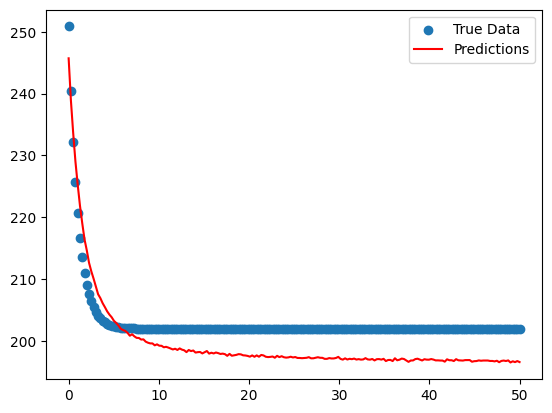

In [18]:
plt.scatter(t_tensor, T_test[-1], label="True Data")
plt.plot(t_tensor, T_pred_test[-1], color="red", label="Predictions")
plt.legend()
plt.show()

20000
20000


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

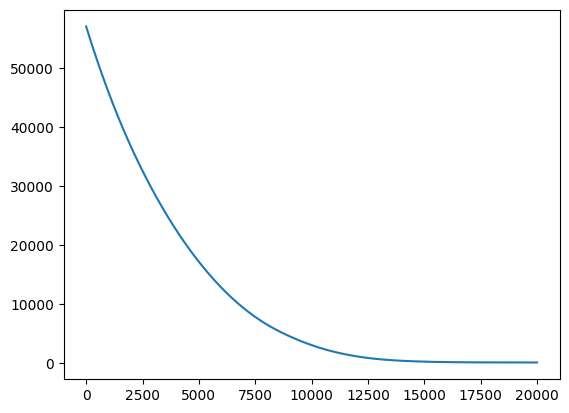

In [19]:
#compute the learning curve
epochs = 20000
epochs_array = np.linspace(0, epochs, epochs)

print(len(test_losses))
print(len(epochs_array))

plt.plot(epochs_array, test_losses, label="test losses")
plt.plot(epochs_array, train_losses, label = "training losses")